In [1]:
import numpy as np
from data_loader import *

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import figure


import keras
from keras.layers import Input, Reshape, Conv2D, MaxPooling2D, ZeroPadding2D, Flatten, Dropout, Dense, LSTM,Activation
from keras.models import Model, load_model
from keras.utils import plot_model, multi_gpu_model

from scipy import signal

import keras.backend as K

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

/home/morads/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_mod_group = 0
val_mod_group = 0
test_mod_group = 2

num_files = 13
# num_files = 5

blc = 0

CLASSES = ['16PSK', '2FSK_5KHz', '2FSK_75KHz', '8PSK', 'AM_DSB', 'AM_SSB', 'APSK16_c34',
 'APSK32_c34', 'BPSK', 'CPFSK_5KHz', 'CPFSK_75KHz', 'FM_NB', 'FM_WB',
 'GFSK_5KHz', 'GFSK_75KHz', 'GMSK', 'MSK', 'NOISE', 'OQPSK', 'PI4QPSK', 'QAM16',
 'QAM32', 'QAM64', 'QPSK']

snr_values = None


mods_for_train = 4

mods1 = [i for i in range(mods_for_train)]
mods1.append(17)
mods1 = np.asarray(mods1)

mods2 = np.arange(mods_for_train,24)

mods3 = np.arange(24)

all_mods = [mods1, mods2, mods3]


train_modulations = np.asarray([CLASSES[i] for i in all_mods[train_mod_group]])
val_modulations = np.asarray([CLASSES[i] for i in all_mods[val_mod_group]])
test_modulations = np.asarray([CLASSES[i] for i in all_mods[test_mod_group]])


snrDict = {
    -10: 0,
     -6: 1,
     -2: 2,
      2: 3,
      6: 4,
     10: 4
}

num_classes = len(set(snrDict.values()))

In [3]:
path = "/datax/yzhang/army_challenge/training_data/"
if blc == 0:
    path = "/datax/yzhang/training_data/"

data = []
for i in range(num_files):
    data_file = path + "training_data_chunk_" + str(i) + ".pkl"
    data.append(LoadModRecData(data_file, 1., 0., 0., load_mods=train_modulations, load_snrs=snr_values, snrDict=snrDict))
    

    
data_file = path + "training_data_chunk_13.pkl"
valdata = LoadModRecData(data_file, 1., 0., 0., load_mods=val_modulations, load_snrs=snr_values, snrDict=snrDict)
    
data_file = path + "training_data_chunk_14.pkl"
testdata = LoadModRecData(data_file, 1., 0., 0., load_mods=test_modulations, load_snrs=snr_values, snrDict=snrDict)



[Data Loader] - Loading Datafile,  /datax/yzhang/training_data/training_data_chunk_0.pkl
[Data Loader] - Counting Number of Examples in Dataset...
[Data Loader] - Number of Examples in Dataset: 60000
[Data Loader] - [Modulation Dataset] Adding Collects for: 16PSK
[Data Loader] - [Modulation Dataset] Adding Collects for: 2FSK_5KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: 2FSK_75KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: 8PSK
[Data Loader] - [Modulation Dataset] Adding Collects for: NOISE
[Data Loader] - Converting to numpy arrays...
[Data Loader] - Shuffling Data...
[Data Loader] - Splitting Data...
[Data Loader] - Train Size: 60000 Validation Size: 0 Test Size: 0
[Data Loader] - Done.

[Data Loader] - Loading Datafile,  /datax/yzhang/training_data/training_data_chunk_1.pkl
[Data Loader] - Counting Number of Examples in Dataset...
[Data Loader] - Number of Examples in Dataset: 60000
[Data Loader] - [Modulation Dataset] Adding Collects for: 16PSK
[Data

[Data Loader] - Shuffling Data...
[Data Loader] - Splitting Data...
[Data Loader] - Train Size: 60000 Validation Size: 0 Test Size: 0
[Data Loader] - Done.

[Data Loader] - Loading Datafile,  /datax/yzhang/training_data/training_data_chunk_12.pkl
[Data Loader] - Counting Number of Examples in Dataset...
[Data Loader] - Number of Examples in Dataset: 60000
[Data Loader] - [Modulation Dataset] Adding Collects for: 16PSK
[Data Loader] - [Modulation Dataset] Adding Collects for: 2FSK_5KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: 2FSK_75KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: 8PSK
[Data Loader] - [Modulation Dataset] Adding Collects for: NOISE
[Data Loader] - Converting to numpy arrays...
[Data Loader] - Shuffling Data...
[Data Loader] - Splitting Data...
[Data Loader] - Train Size: 60000 Validation Size: 0 Test Size: 0
[Data Loader] - Done.

[Data Loader] - Loading Datafile,  /datax/yzhang/training_data/training_data_chunk_13.pkl
[Data Loader] - Count

In [4]:
def inception(input_img, fs=[64,64,64,64,64],height = 2, widths = [8,4],  with_residual=False):
    tower_1 = Conv2D(filters=fs[0], kernel_size=[height, 1], padding='same',activation='relu')(input_img)
    tower_2 = Conv2D(filters=fs[2], kernel_size=[height, 1], padding='same',activation='relu')(input_img)
    tower_2 = Conv2D(filters=fs[3], kernel_size=[height, widths[0]], padding='same',activation='relu')(tower_2)
    tower_3 = Conv2D(filters=fs[2], kernel_size=[height, 1], padding='same',activation='relu')(input_img)
    tower_3 = Conv2D(filters=fs[3], kernel_size=[height, widths[1]], padding='same',activation='relu')(tower_3)
    tower_4 = MaxPooling2D(3, strides=1, padding='same')(input_img)
    tower_4 = Conv2D(filters=fs[4], kernel_size=1, padding='same',activation='relu')(tower_4)
    
    if len(widths) == 3:
        tower_5 = Conv2D(filters=fs[2], kernel_size=[height, 1], padding='same',activation='relu')(input_img)
        tower_5 = Conv2D(filters=fs[3], kernel_size=[height, widths[2]], padding='same',activation='relu')(tower_5)
        output = keras.layers.concatenate([tower_1, tower_2, tower_3, tower_4, tower_5], axis = 3)
    else:
        output = keras.layers.concatenate([tower_1, tower_2, tower_3, tower_4], axis = 3)
    if with_residual and output.shape==input_img.shape:
        output = output+input_img
    return output

def out_tower(x, dr=0.5):
    x = Dropout(dr)(x)
    output = Flatten()(x)
    logits = Dense(num_classes)(output)
    out = Activation('softmax')(logits)
    return out



def googleNet(x, data_format='channels_last', num_classes=24, num_layers = [1,1,1,1],features=[1,1,1,1,1]):
    x = Reshape(in_shp + (1,), input_shape=in_shp)(x)
    x = Conv2D(filters = 32*features[0], kernel_size=[2,6], strides=[1,2], data_format=data_format, padding='same', activation='relu')(x)
    x = MaxPooling2D([1, 3], strides=[1,2], padding='same')(x)
    for dep in range(num_layers[0]):
        x = Conv2D(filters = 32*features[1], kernel_size=[1, 3], strides=[1,1], padding='same', activation='relu')(x)
    x = MaxPooling2D([1,3], strides=[1,2], padding='same')(x)
    for dep in range(num_layers[1]):
        x = inception(x, widths=[8,4], fs=[16,16,16,16,16]*features[2])
    x = MaxPooling2D(3, strides=2, padding='same')(x)
    for dep in range(num_layers[2]):
        x = inception(x, widths=[8,4], fs=[8,8,8,8,8]*features[3], with_residual=True)
    x = MaxPooling2D(3, strides=2, padding='same')(x)
    for dep in range(num_layers[3]):
        x = inception(x, widths=[6,4],height = 1, fs=[8,8,8,8,8]*features[4])
        
    out = out_tower(x, dr=0.5)
    return out

in_shp = (2, 1024)
input_img = Input(shape=in_shp)

# for our final model we used num_layers = [1,2,6,2]
out = googleNet(input_img,data_format='channels_last', num_classes=num_classes, num_layers = [1,1,1,1])
model = Model(inputs=input_img, outputs=out)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2, 1024)      0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 2, 1024, 1)   0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 2, 512, 32)   416         reshape_1[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 2, 256, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

In [5]:
# Uncomment to visualize architecture
# plot_model(model, to_file='model.png', show_shapes = True)

# figure(figsize = (15,20))
# img = mpimg.imread('model.png')
# plt.imshow(img, aspect='auto')
# plt.show()

In [6]:
# We trained till completion
train_batch_size, number_of_epochs = 512, 15

val_batches = valdata.batch_iter(valdata.train_idx,train_batch_size,number_of_epochs,use_shuffle=False,train_snr=True)
vsteps = valdata.train_idx.size//train_batch_size


generators = []
tsteps = 0
for i,d in enumerate(data):
    print("Adding generator for file ", i)
    generators.append(d.batch_iter(d.train_idx,train_batch_size,number_of_epochs,use_shuffle=False,train_snr=True))
    tsteps += d.train_idx.size

tsteps = tsteps//train_batch_size 

def train_batches(noise=None):
    while True:
        batches_x, batches_y = [], []

        for gen in generators:
            batch_x, batch_y = next(gen)
            batches_x.append(batch_x)
            batches_y.append(batch_y)
            
        batches_x = np.concatenate(batches_x)
        batches_y = np.concatenate(batches_y)
        
        if noise:
            x,y,z = batches_x.shape
            batches_x += noise * np.random.randn(x, y, z)
        idx = np.random.permutation(batches_x.shape[0])
        
        batches_x = batches_x[idx]
        batches_y = batches_y[idx]
        
        for i in range(len(generators)):
            beg = i * train_batch_size
            end = beg + train_batch_size
            yield batches_x[beg:end], batches_y[beg:end]
        

train_batches = train_batches(noise=0.25)

Adding generator for file  0
Adding generator for file  1
Adding generator for file  2
Adding generator for file  3
Adding generator for file  4
Adding generator for file  5
Adding generator for file  6
Adding generator for file  7
Adding generator for file  8
Adding generator for file  9
Adding generator for file  10
Adding generator for file  11
Adding generator for file  12


In [7]:
# model = multi_gpu_model(model, gpus=2)

# optimizer = keras.optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
# model.compile(loss='categorical_crossentropy', optimizer=optimizer)

model.compile(loss='categorical_crossentropy', optimizer='adam')

filepath = '/tmp/morads/convmodrecnets_CNN2_0.5.wts.h5'

try:
    history = model.fit_generator(train_batches,
        nb_epoch=number_of_epochs,
        steps_per_epoch=tsteps,
        verbose=1,
        validation_data=val_batches,
        validation_steps=vsteps,
         callbacks = [
              keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
              keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='auto')
         ]) 
except(StopIteration):
    pass

model.save('mod_classifier21.h5')  
model = load_model(filepath)

# print("Done")

/home/morads/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/morads/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=1523, verbose=1, validation_data=<generator..., validation_steps=117, callbacks=[<keras.ca..., epochs=15)`


Epoch 1/15
1523/1523 [==============================] - 119s 78ms/step - loss: 0.0556 - val_loss: 0.0178
Epoch 2/15
1523/1523 [==============================] - 125s 82ms/step - loss: 4.0195e-04 - val_loss: 0.0077
Epoch 3/15
1523/1523 [==============================] - 127s 83ms/step - loss: 2.3966e-04 - val_loss: 0.0072
Epoch 4/15
1523/1523 [==============================] - 135s 89ms/step - loss: 1.0855 - val_loss: 2.6992
Epoch 5/15
1523/1523 [==============================] - 122s 80ms/step - loss: 2.6846 - val_loss: 2.7021
Epoch 6/15
1523/1523 [==============================] - 166s 109ms/step - loss: 2.6858 - val_loss: 2.7010


In [16]:
# filepath = '/tmp/morads/convmodrecnets_CNN2_0.5.wts.h5'

model2 = model
model = load_model(filepath)

In [17]:
# model = model2

2437/2437 [==============================] - 350s 144ms/step - loss: 0.7716 - val_loss: 2.7843 <br>
2437/2437 [==============================] - 338s 139ms/step - loss: 2.6873 - val_loss: 2.7907 <br>
2437/2437 [==============================] - 340s 139ms/step - loss: 2.4595 - val_loss: 0.0896 <br>
2437/2437 [==============================] - 339s 139ms/step - loss: 1.8436e-04 - val_loss: 0.0971 <br>
2437/2437 [==============================] - 339s 139ms/step - loss: 0.0099 - val_loss: 0.1190 <br>
2437/2437 [==============================] - 339s 139ms/step - loss: 1.3700e-04 - val_loss: 0.0890 <br>
2437/2437 [==============================] - 339s 139ms/step - loss: 0.0160 - val_loss: 0.1053 <br>
2437/2437 [==============================] - 339s 139ms/step - loss: 8.6887e-05 - val_loss: 0.1143 <br>
2437/2437 [==============================] - 339s 139ms/step - loss: 3.6859e-04 - val_loss: 0.0962 <br>
2437/2437 [==============================] - 339s 139ms/step - loss: 0.0079 - val_loss: 0.1248 <br>
2437/2437 [==============================] - 339s 139ms/step - loss: 4.1867e-05 - val_loss: 0.1192 <br>


In [13]:
# Plot confusion matrix

# model = load_model(filepath)
acc = {}
snrs = np.arange(-15,15, 5)

classes = testdata.modTypes

print("classes ", classes)
for snr in testdata.snrValues:

    # extract classes @ SNR
    snrThreshold_lower = snr
    snrThreshold_upper = snr+2
    snr_bounded_test_indicies = testdata.get_indicies_withSNRthrehsold(testdata.train_idx, snrThreshold_lower, snrThreshold_upper)
    
    test_X_i = testdata.signalData[snr_bounded_test_indicies]
#     test_Y_i = testdata.oneHotLabels[snr_bounded_test_indicies] 
    test_Y_i = testdata.snrLabels[snr_bounded_test_indicies] 

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([num_classes,num_classes])
    confnorm = np.zeros([num_classes,num_classes])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,num_classes):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
#     plt.figure(figsize=(10,10))
#     plot_confusion_matrix(confnorm, labels=["-10", "-6", "-2", "2","6", "10"], title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("SNR", snr, "Overall Accuracy: ", cor / (cor+ncor), "Out of", len(snr_bounded_test_indicies))
    acc[snr] = 1.0*cor/(cor+ncor)
    plt.show()

classes  ['16PSK' '2FSK_5KHz' '2FSK_75KHz' '8PSK' 'AM_DSB' 'AM_SSB' 'APSK16_c34'
 'APSK32_c34' 'BPSK' 'CPFSK_5KHz' 'CPFSK_75KHz' 'FM_NB' 'FM_WB'
 'GFSK_5KHz' 'GFSK_75KHz' 'GMSK' 'MSK' 'NOISE' 'OQPSK' 'PI4QPSK' 'QAM16'
 'QAM32' 'QAM64' 'QPSK']


/home/morads/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


SNR -10 Overall Accuracy:  1.0 Out of 48000
SNR -6 Overall Accuracy:  1.0 Out of 48000
SNR -2 Overall Accuracy:  0.9999583333333333 Out of 48000
SNR 2 Overall Accuracy:  0.9760625 Out of 48000
SNR 6 Overall Accuracy:  0.9954375 Out of 48000
SNR 10 Overall Accuracy:  0.9984583333333333 Out of 48000


In [14]:

# path = "/datax/yzhang/training_data/"
# test_mod_group = 1
# test_modulations = np.asarray([CLASSES[i] for i in all_mods[1]])

# data_file = path + "training_data_chunk_14.pkl"
# testdata = LoadModRecData(data_file, 1., 0., 0., load_mods=test_modulations, load_snrs=[10], snrDict=snrDict)


classes  ['16PSK' '2FSK_5KHz' '2FSK_75KHz' '8PSK' 'AM_DSB' 'AM_SSB' 'APSK16_c34'
 'APSK32_c34' 'BPSK' 'CPFSK_5KHz' 'CPFSK_75KHz' 'FM_NB' 'FM_WB'
 'GFSK_5KHz' 'GFSK_75KHz' 'GMSK' 'MSK' 'NOISE' 'OQPSK' 'PI4QPSK' 'QAM16'
 'QAM32' 'QAM64' 'QPSK']
Overall Accuracy:  0.9949861111111111 Out of 48000


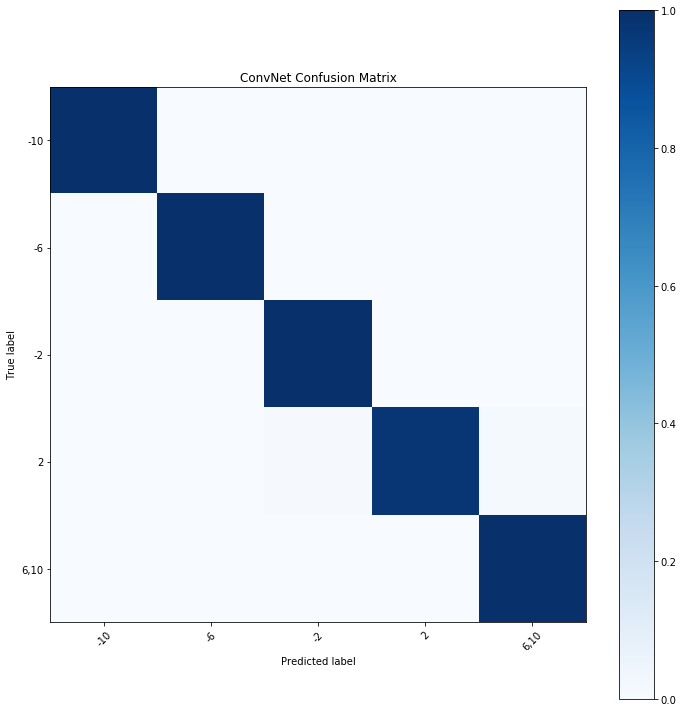

In [18]:

# Plot confusion matrix

# model = load_model('mod_classifier21.h5')
acc = {}
snrs = np.arange(-15,15, 5)

classes = testdata.modTypes

print("classes ", classes)

test_X_i = np.copy(testdata.signalData)


#### adding noise
# x,y,z = test_X_i.shape
# noise = 0.5
# test_X_i += noise * np.random.randn(x, y, z)
#####



#     test_Y_i = testdata.oneHotLabels[snr_bounded_test_indicies] 
test_Y_i = testdata.snrLabels

# estimate classes
test_Y_i_hat = model.predict(test_X_i)
conf = np.zeros([num_classes,num_classes])
confnorm = np.zeros([num_classes,num_classes])
for i in range(0,test_X_i.shape[0]):
    j = list(test_Y_i[i,:]).index(1)
    k = int(np.argmax(test_Y_i_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,num_classes):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plt.figure(figsize=(10,10))
plot_confusion_matrix(confnorm, labels=["-10","-6","-2","2","6,10"], title="ConvNet Confusion Matrix")

cor = np.sum(np.diag(conf))
ncor = np.sum(conf) - cor
print("Overall Accuracy: ", cor / (cor+ncor), "Out of", len(snr_bounded_test_indicies))
acc[snr] = 1.0*cor/(cor+ncor)
plt.show()